## Import required packages

In [33]:
import os
import tifffile
import numpy as np
import math

%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Set the paths to images

In [17]:
work_dir = os.getcwd()
examples_dir = os.path.dirname(work_dir)
mitochondria_dir = os.path.join(examples_dir, 'images', 'mitochondria')
IMAGE_PATH = os.path.join(mitochondria_dir, 'ASY15-1_0nM-10_s10_mNeon.tif')
LABELS_PATH = os.path.join(mitochondria_dir, 'ASY15-1_0nM-10_s10_segm.npz')
IMAGE_PATH

'g:\\My Drive\\01_Postdoc_HMGU\\Python_MyScripts\\MIA\\Git\\spotMAX_v2\\examples\\images\\mitochondria\\ASY15-1_0nM-10_s10_mNeon.tif'

## Load images
Load the spots image and the segmentation data of the cells (`lab`)

In [18]:
image = tifffile.tifffile.imread(IMAGE_PATH)
image.shape, image.dtype

((43, 377, 377), dtype('uint8'))

In [19]:
lab = np.load(LABELS_PATH)['arr_0']
lab.shape, lab.dtype

((377, 377), dtype('uint32'))

## Visualize max projection of loaded data

Text(0.5, 1.0, 'Segmented cells')

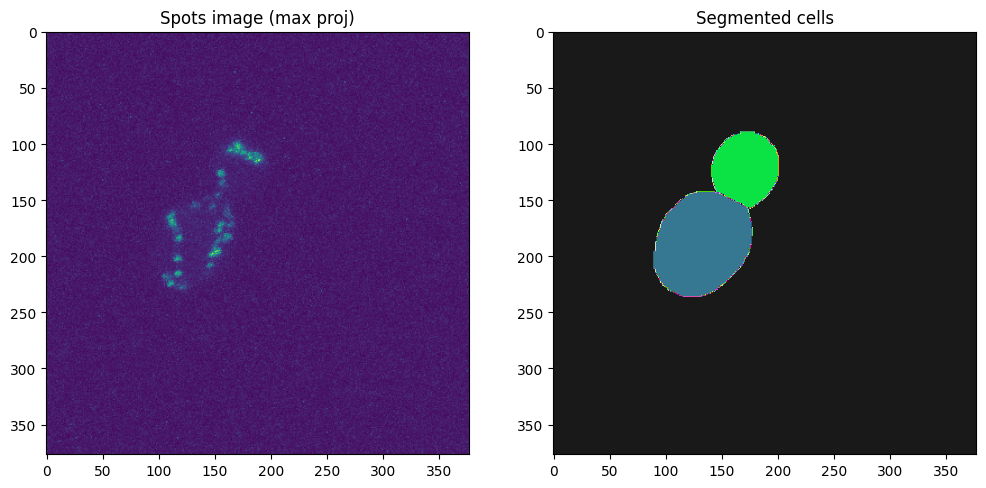

In [20]:
import matplotlib.pyplot as plt
import matplotlib

spots_img_max = image.max(axis=0)

fig, ax = plt.subplots(1, 2, figsize=(12,8))
ax[0].imshow(spots_img_max)
ax[0].set_title('Spots image (max proj)')

random_colors = np.random.rand(256,3)
# Dark color for background
random_colors[0] = (0.1, 0.1, 0.1)
cmap = matplotlib.colors.ListedColormap(random_colors)

ax[1].imshow(lab, cmap=cmap)
ax[1].set_title('Segmented cells')

## Segment the spots
By segmenting the spots image we get a mask where to detect the spots. 

This is a **crucial step**. It is worth testing all the available methods which are several algortithms for automatic thresholding, the spotMAX neural network, and any of the models from the [BioImage.IO Model Zoo](https://bioimage.io).

Here we show how to visualize the result for all the methods and proceed with the selected one. 

### Initialize spotMAX neural network

In [21]:
import spotmax.nnet.model

nnet_model = spotmax.nnet.model.Model(
    model_type='2D',
    preprocess_across_experiment=False,
    preprocess_across_timepoints=False,
    gaussian_filter_sigma=0,
    remove_hot_pixels=False, 
    PhysicalSizeX=0.073,
    resolution_multiplier_yx=1.0,
    use_gpu=False,
)
nnet_params = {
    'segment': {
        'threshold_value': 0.9,
        'label_components': False
    }
}

### Initialize BioImage.IO model

In [22]:
import spotmax.BioImageIO.model

model_doi = '10.5281/zenodo.5764892'
bioimageio_model = spotmax.BioImageIO.model.Model(
    model_doi_url_or_zip_path=model_doi
)
bioimageio_params = {
    'segment': {
        'threshold_value': 0.9,
        'output_index': 0,
        'label_components': False
    }
}

c:\Users\Francesco\.virtualenvs\acdc\lib\site-packages\bioimageio\spec\shared\schema.py:46: ValidationWarning: tags: Missing tags corresponding to bioimage.io categories: [{'framework': ['tensorflow', 'pytorch', 'tensorflow.js']}, {'software': ['ilastik', 'imagej', 'fiji', 'imjoy', 'deepimagej', 'n2v']}]
  warnings.warn(msg, category=ValidationWarning)
c:\Users\Francesco\.virtualenvs\acdc\lib\site-packages\bioimageio\spec\shared\schema.py:46: ValidationWarning: weights:torchscript: missing 'pytorch_version'
  warnings.warn(msg, category=ValidationWarning)
computing dataset statistics: 0it [00:00, ?it/s]


### Segment with all the automatic thresholding methods

In [38]:
import spotmax.pipe

# Rough estimate for the radii of the spots in pixels. This can be 
# estimated visually
spots_zyx_radii_pxl = (3.5, 5, 5)

spots_segm_result = spotmax.pipe.spots_semantic_segmentation(
    image, 
    lab=lab,
    gauss_sigma=0.75,
    spots_zyx_radii_pxl=spots_zyx_radii_pxl, 
    do_sharpen=True, 
    do_remove_hot_pixels=False,
    lineage_table=None,
    do_aggregate=True,
    use_gpu=False,
    logger_func=print,
    thresholding_method=None,
    keep_input_shape=True,
    nnet_model=nnet_model,
    nnet_params=nnet_params,
    nnet_input_data=None,
    bioimageio_model=bioimageio_model,
    bioimageio_params=bioimageio_params,
    do_preprocess=True,
    do_try_all_thresholds=True,
    return_only_segm=False,
    pre_aggregated=False,
    raw_image=None
)
print('Semantic segmentation done.')

########################################
######## Model Configuration ###########
########################################
Model: unet2D
Operation: predict
Configuration:
{'model': {'name': 'UNet2D',
           'n_channels': 1,
           'n_classes': 2,
           'bilinear': True,
           'model_dir': '~/spotmax_appdata/unet_checkpoints/checkpoints/unet2D',
           'best_model_path': '~/spotmax_appdata/unet_checkpoints/unet2D/unet_best.pth',
           'training_path': '~/spotmax_appdata/unet_checkpoints/unet2D/training/'},
 'trainer': {'batch_size': 16,
             'epochs': 1,
             'learning_rate': 0.001,
             'save_checkpoint': True,
             'amp': False,
             'wandb_mode': 'disabled'},
 'default_params': {'threshold_value': 0.9}}
########################################


Semantic segmentation done.


### Visualize results of semantic segmentation
We can see that the `neural_network` probably returns the best result (all spots are segmented and non-spots area are minimized). However, `threshold_li` and `threshold_yen` are not bad either. On the other hand, the worst result is probably with `threshold_mean`. 

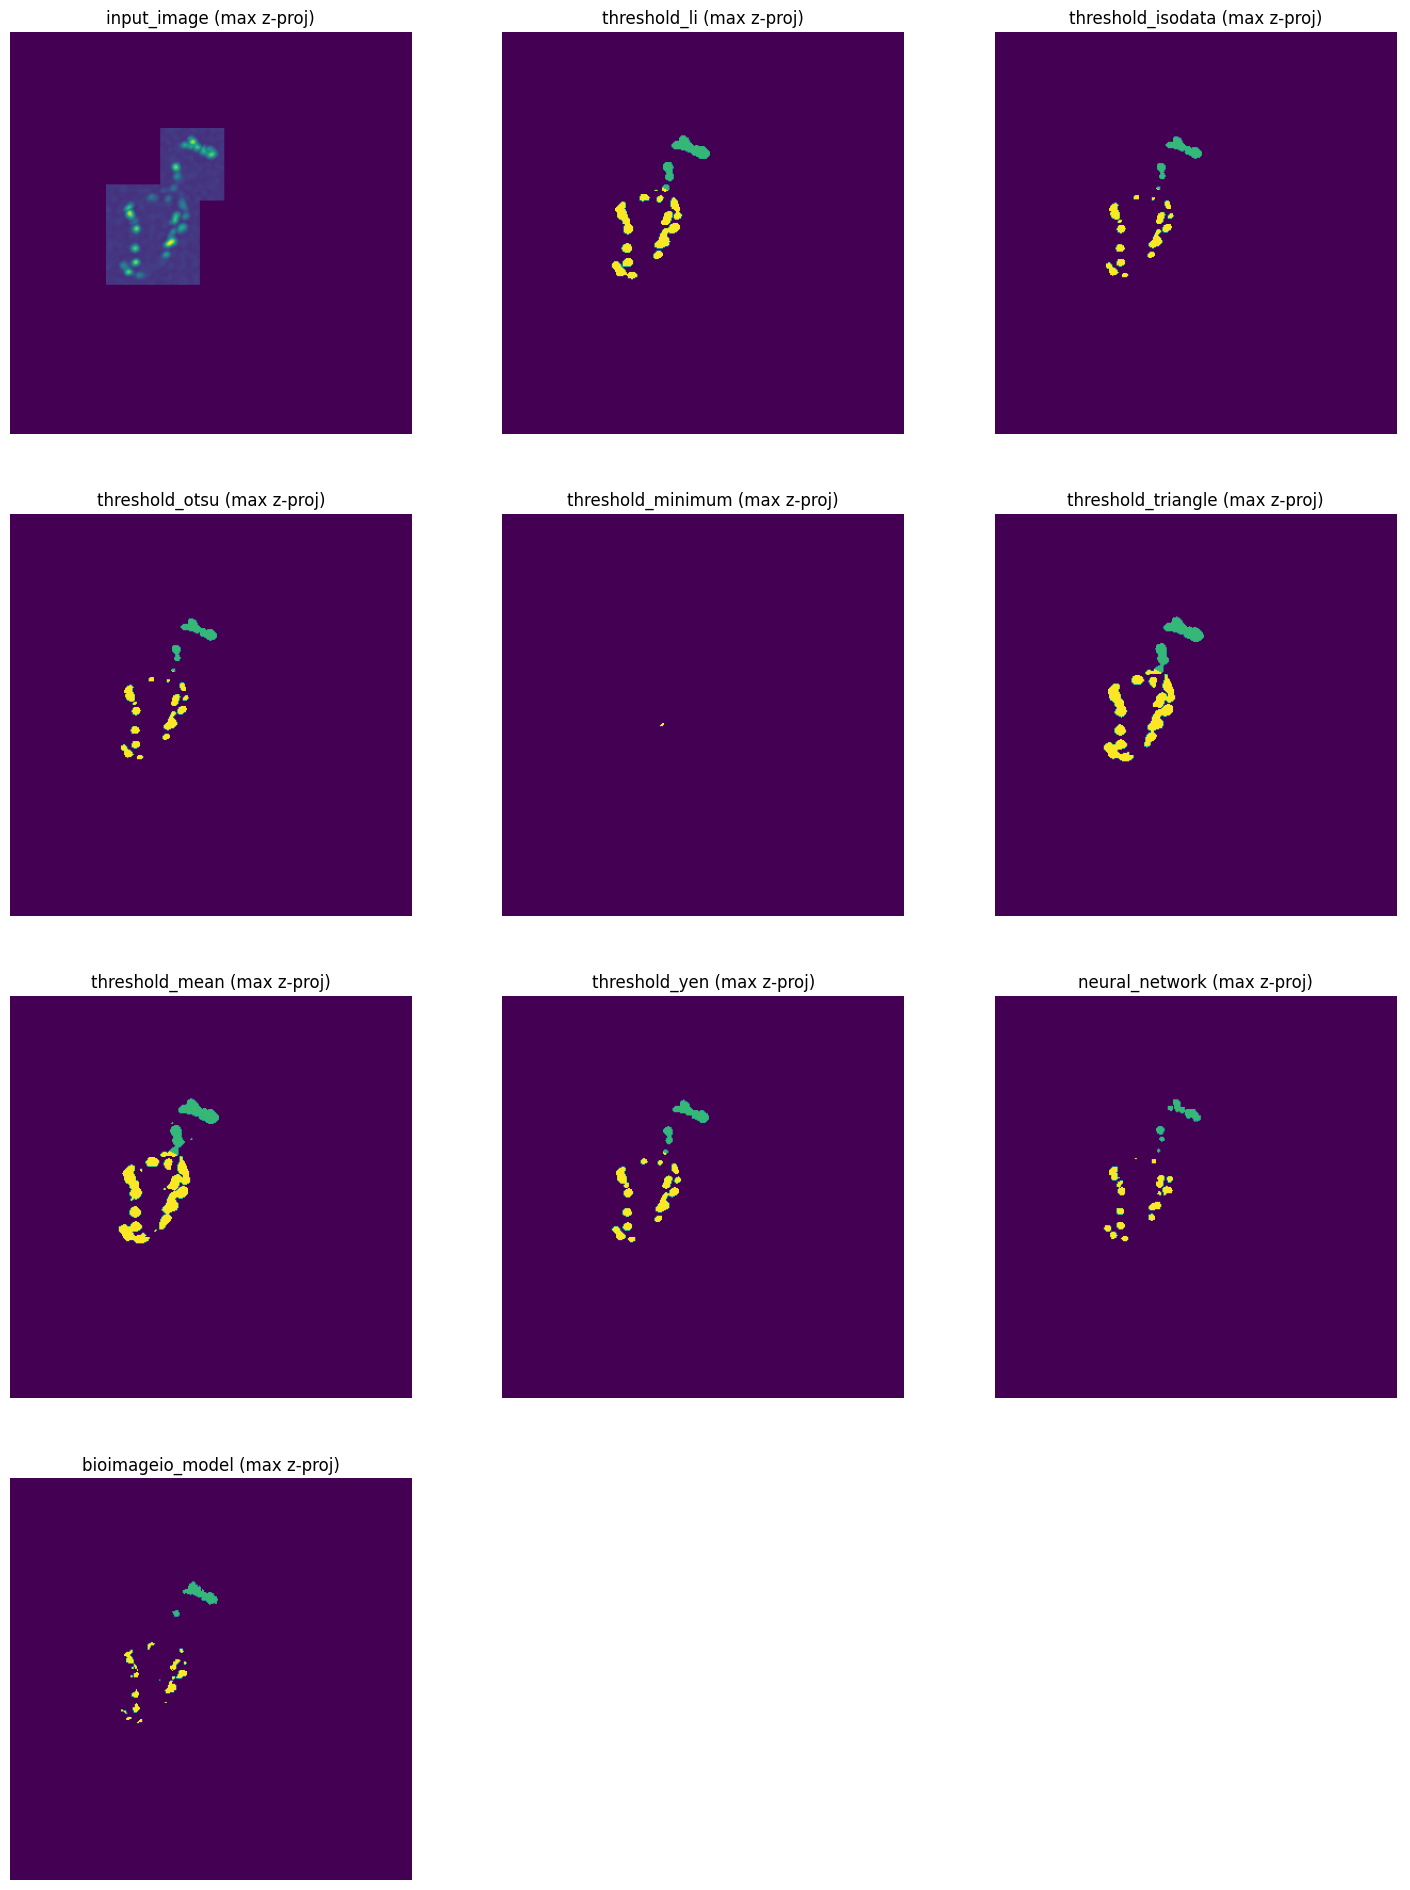

In [39]:
ncols = 3
nplots = len(spots_segm_result)
nrows = math.ceil(nplots / ncols)
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*6, nrows*6))
ax = ax.flatten()
for i, (key, img) in enumerate(spots_segm_result.items()):
    ax[i].imshow(img.max(axis=0))
    ax[i].set_title(f'{key} (max z-proj)')

for axes in ax:
    axes.axis('off')

We proceed to detect the spots using `neural_network` result. Note that if you already know which method to use you don't need to evaluate all of them, which saves quite some computation time. 

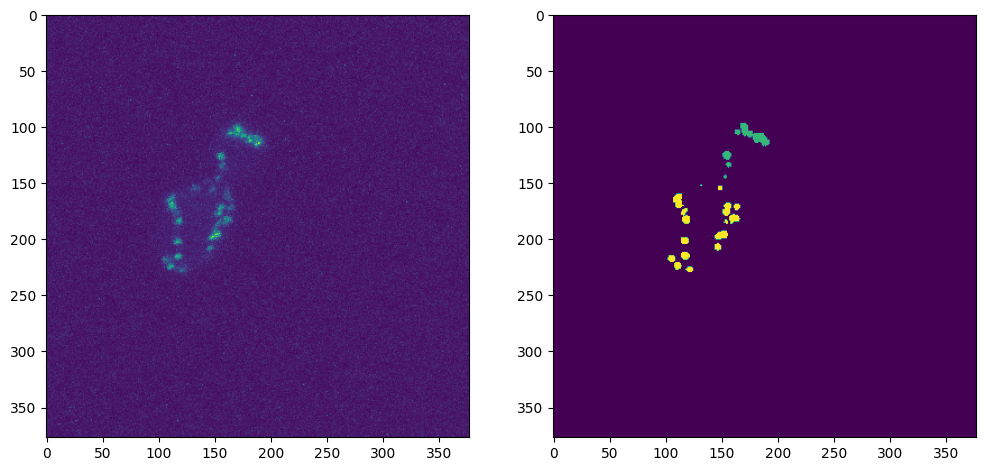

In [40]:
SELECTED_METHOD = 'neural_network'
spots_labels = spots_segm_result[SELECTED_METHOD]

fig, ax = plt.subplots(1, 2, figsize=(12,8))
ax[0].imshow(image.max(axis=0))
ax[1].imshow(spots_labels.max(axis=0))

## Detect spots

In [44]:
import pandas as pd

%autoreload 2

import spotmax.pipe

df_spots_coords, spots_objs = spotmax.pipe.spot_detection(
    spots_segm_result['input_image'],
    spots_segmantic_segm=spots_labels,
    detection_method='peak_local_max',
    spot_footprint=None,
    spots_zyx_radii_pxl=spots_zyx_radii_pxl,
    return_spots_mask=False,
    return_df=True
)

In [27]:
df_spots_coords.head(10)

,z,y,x
Cell_ID,,,
2,20,115,189
2,16,102,170
2,20,112,183
2,20,115,187
2,15,104,171
2,21,110,180
2,20,113,181
2,20,107,169
2,17,101,172


## Visualize detected spots

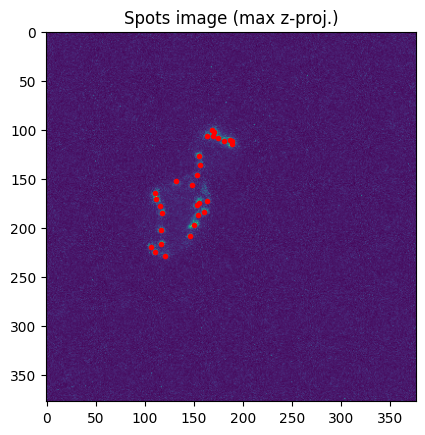

In [47]:
fig, ax = plt.subplots()

ax.imshow(image.max(axis=0))
ax.set_title('Spots image (max z-proj.)')
ax.plot(df_spots_coords['x'], df_spots_coords['y'], 'r.')

### Visualize with interactive window
Open a GUI where you can scroll through the z-slices, pan, and zoom the image.

It requires the `cellacdc` pacakge with GUI libraries and a desktop environment

In [ ]:
from cellacdc.plot import imshow
imshow(image, points_coords_df=df_spots_coords)

## Filter valid spots from features

If we are not happy with the detection yet, we can filter the spots based on features such and the signal-to-noise ratio (SNR) or the size of the spots. 

Here we show how to filter based on the Effect size, which is a measure of the SNR. 

### Calculate and explore spots features
By keeping `gop_filtering_thresholds=None` we do not filter yet and we get only the features of the detected spots (as a pandas.DataFrame)

In [51]:
keys, dfs_spots_det, _ = spotmax.pipe.spots_calc_features_and_filter(
    spots_segm_result['input_image'], 
    spots_zyx_radii_pxl,
    df_spots_coords,
    frame_i=0,
    sharp_spots_image=None,
    lab=lab,
    rp=None,
    gop_filtering_thresholds=None,
    delta_tol=None,   
    raw_image=image,
    ref_ch_mask_or_labels=None, 
    ref_ch_img=None,   
    keep_only_spots_in_ref_ch=False,
    min_size_spheroid_mask=None,
    optimise_for_high_spot_density=True,
    dist_transform_spheroid=None,
    get_backgr_from_inside_ref_ch_mask=False,
    show_progress=True,
    verbose=True,
    logger_func=print
)


Filtering valid spots...


KeyError: "None of [Index(['z_local', 'y_local', 'x_local'], dtype='object')] are in the [columns]"